In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import pyphot

#sys.path.append('../..')
#import wdtools_nicole as wdtools

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [ ]:
from astropy.table import Table
data = Table.read("data/passbands.fits").to_pandas()
data['lambda'] *= 10
data.replace(99.99, 0, inplace=True)

interp_spec = interpolator.WarwickSpectrum(model='1d_da_nlte', units = 'flam', wavl_range = (100,30000))
Gpb = np.interp(interp_spec.wavl, data['lambda'], data.GPb)
BPpb = np.interp(interp_spec.wavl, data['lambda'], data.BPPb)
RPpb = np.interp(interp_spec.wavl, data['lambda'], data.RPPb)
passes = np.array([Gpb, BPpb, RPpb])

In [23]:
"""compute the radial velocity from radius and effective temperature
"""
mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
font_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_function = WD_models.interp_xy_z_func(x = 10**font_model['logteff'], y = font_model['logg'],\
                                            z = rsun, interp_type = 'linear')

In [ ]:
def get_model_flux(teff, logg):
    pc_to_m, radius_sun = 3.08568e16, 6.957e8
    radius = logg_function(teff, logg)
    f_lam = 4*np.pi * interp_spec.model_spec((teff,logg)) * (radius*radius_sun)**2
    num = np.trapezoid(f_lam * passes * interp_spec.wavl, interp_spec.wavl)
    den = np.trapezoid(passes * interp_spec.wavl, interp_spec.wavl)
    return num/den /(10*pc_to_m)**2

def mag_to_flux(mag : np.array, e_mag : np.array):
    """convert vega magnitudes to fluxes in flam units
    """
    flux = np.power(10, -0.4*(mag - np.array([-21.48503, -20.96683, -22.22089])))  
    e_flux = 1.09 * flux * e_mag
    return flux, e_flux

def loss(params, fl, e_fl):
    teff, logg = params.valuesdict().values()
    flux_model = get_model_flux(teff, logg)
    return (fl - flux_model) / e_fl

In [25]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL and meanAV is not NULL and RPlx > 3"""
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [36]:
import lmfit

values = np.zeros((len(ngfdata), 4))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    extinction = np.array([0.835*row.meanAV, 1.139*row.meanAV, 0.650*row.meanAV])
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values - extinction + 5*(np.log10((row.Plx - row.ZPcor)*1e-3) + 1)
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = mag_to_flux(mags, e_mags)

    params = lmfit.Parameters()
    params.add('teff', value=10000, min=2000, max=50000, vary=True)
    params.add('logg', value=8, min=7.1, max=9, vary=True)

    res = lmfit.minimize(loss, params, args = (fluxes, e_fluxes))
    teff, logg = res.params['teff'].value, res.params['logg'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = logg
    values[i,3] = res.redchi
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'logg', 'redchi'])


100%|██████████| 1000/1000 [00:09<00:00, 109.84it/s]


In [37]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.MassH.values, ngfdata.TeffH.values, Hlayer = 'thick')
leastsq['radius'] = logg_function(leastsq.teff, leastsq.logg)
leastsq['mass'] = (1e-2*10**leastsq.logg * ((leastsq.radius*radius_sun)**2 / newton_G))/mass_sun
leastsq = leastsq.query("mass > 0.46")

In [38]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.TeffH) / comparison.teff * 100
comparison['logg_pct_err'] = (comparison.logg - comparison.loggH) / comparison.logg * 100
comparison['ngf_dist'] = 1000 / (comparison.Plx + comparison.ZPcor)

(-3.0, 3.0)

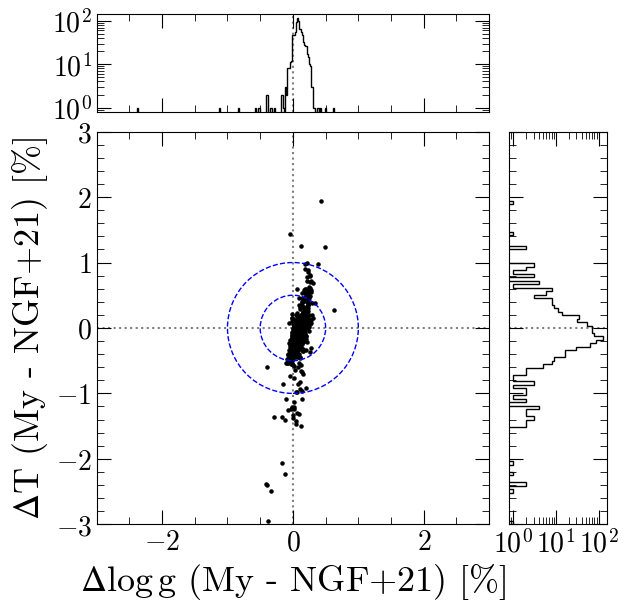

In [39]:
import matplotlib.patches as patches

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    scatter = ax.scatter(x, y, c='k', s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    # now determine nice limits by hand:
    binwidth = 0.5
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth
    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    return scatter

#fig, ax = plt.subplots(ncols=1, figsize=(8,6), sharey=False)
fig = plt.figure(layout='constrained', figsize=(8,6))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

temp_compare = comparison.copy()
scatter_mass = scatter_hist(temp_compare.logg_pct_err, temp_compare.teff_pct_err, ax = ax, 
                            ax_histx = ax_histx, ax_histy = ax_histy)
confidence_ellipses = [0.5, 1]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta \log g$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

#xvals = np.linspace(-20,20,100)
#ax.plot(xvals, 0.08*xvals**2-1)

#fig.tight_layout()